In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.models import resnet50
import pkbar
from tqdm import tqdm
import json
import dataset_factory
from experiment import Experiment
import coco_dataset
import vocab
import warnings
warnings.filterwarnings("ignore")

f = open("./default.json")

config = json.load(f)

Using CUDA
Using CUDA


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Running Experiment:  default
loading annotations into memory...
Done (t=0.71s)
creating index...
index created!
loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
Using the saved vocab.
loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
loading annotations into memory...
Done (t=0.65s)
creating index...
index created!
loading annotations into memory...
Done (t=0.32s)
creating index...
index created!


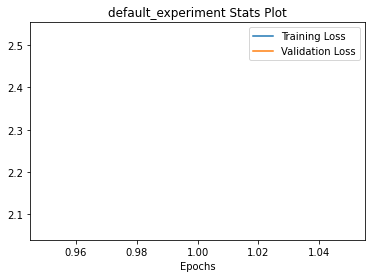

Epoch: 1, Train Loss: 2.5302295944209776, Val Loss: 2.063577153132512, Took 0:03:45.050458, ETA: 0:33:45.454122



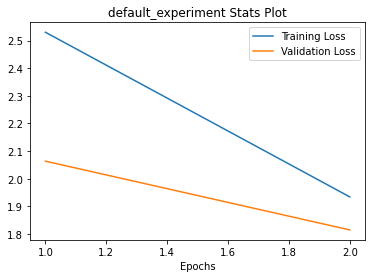

Epoch: 2, Train Loss: 1.9342590697845163, Val Loss: 1.814682487799571, Took 0:03:42.888779, ETA: 0:29:43.110232



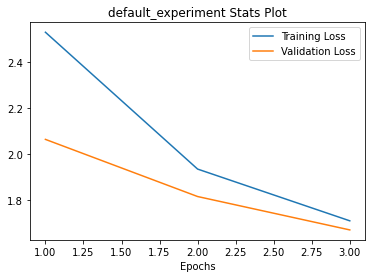

Epoch: 3, Train Loss: 1.708854568055771, Val Loss: 1.6692492485046386, Took 0:03:42.580906, ETA: 0:25:58.066342



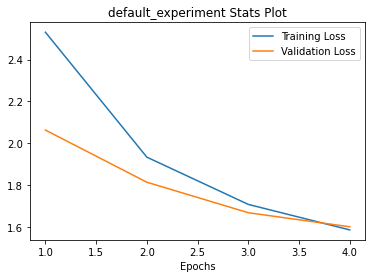

Epoch: 4, Train Loss: 1.5872157715932493, Val Loss: 1.6020974049201377, Took 0:03:41.594848, ETA: 0:22:09.569088



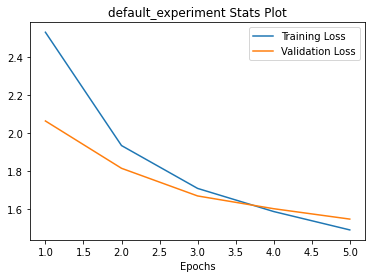

Epoch: 5, Train Loss: 1.4905611305277746, Val Loss: 1.5475063278124883, Took 0:03:42.333734, ETA: 0:18:31.668670



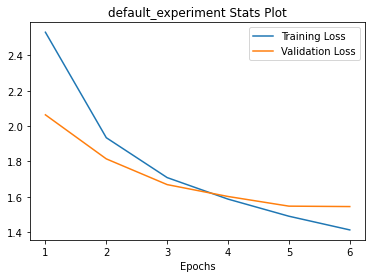

Epoch: 6, Train Loss: 1.4131885488145852, Val Loss: 1.5451387996856982, Took 0:03:40.357326, ETA: 0:14:41.429304



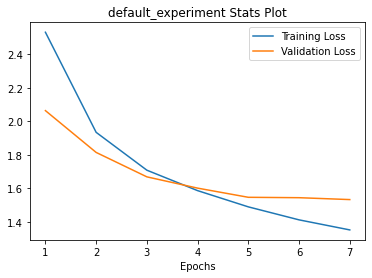

Epoch: 7, Train Loss: 1.3533114051614197, Val Loss: 1.5339307977603032, Took 0:03:46.685164, ETA: 0:11:20.055492



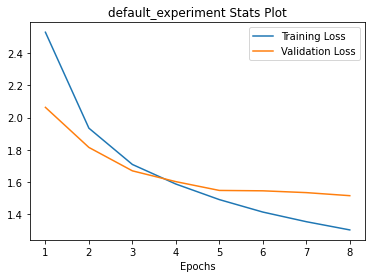

Epoch: 8, Train Loss: 1.302240270606438, Val Loss: 1.514926496377358, Took 0:03:47.307300, ETA: 0:07:34.614600



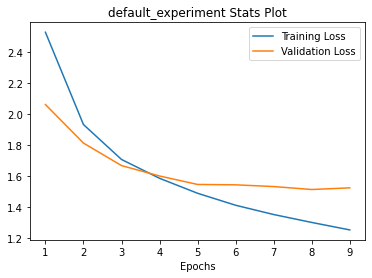

Epoch: 9, Train Loss: 1.2540074372496217, Val Loss: 1.5255921904857341, Took 0:03:47.374172, ETA: 0:03:47.374172



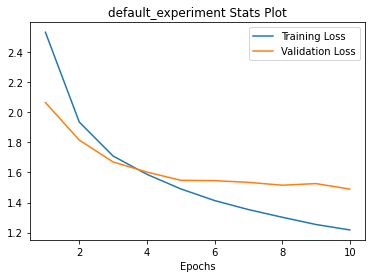

Epoch: 10, Train Loss: 1.21808254580641, Val Loss: 1.4889940376465136, Took 0:03:48.396474, ETA: 0:00:00



AttributeError: 'list' object has no attribute 'eval'

In [3]:
exp_name = 'default'

print("Running Experiment: ", exp_name)
exp = Experiment(exp_name)
exp.run()
exp.test()